In [ ]:
try:
    import open_clip
    from optim_utils import * 
except ModuleNotFoundError:
    # You only really need this safety net if you want to run these notebooks directly in the examples directory
    # Don't worry about this if you installed the package or moved the notebook to the main directory.
    import os; os.chdir("..")
    import open_clip
    from optim_utils import * 

import torch
import mediapy as media
import argparse

## Load Arguments

In [2]:
args = argparse.Namespace()
args.__dict__.update(read_json("sample_config.json"))
args

Namespace(prompt_len=8, iter=3000, lr=0.1, weight_decay=0.1, prompt_bs=1, print_step=100, batch_size=1, clip_model='ViT-H-14', clip_pretrain='laion2b_s32b_b79k')

## Load Clip Model

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, _, preprocess = open_clip.create_model_and_transforms(args.clip_model, pretrained=args.clip_pretrain, device=device)

## Load Diffusion Model

In [4]:
from diffusers import DPMSolverMultistepScheduler, StableDiffusionPipeline

model_id = "stabilityai/stable-diffusion-2-1-base"
scheduler = DPMSolverMultistepScheduler.from_pretrained(model_id, subfolder="scheduler")

pipe = StableDiffusionPipeline.from_pretrained(
    model_id,
    scheduler=scheduler,
    torch_dtype=torch.float16,
    revision="fp16",
    )
pipe = pipe.to(device)

image_length = 512

Error caught was: No module named 'triton'
Fetching 12 files: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 869.62it/s]


## Load Target Image


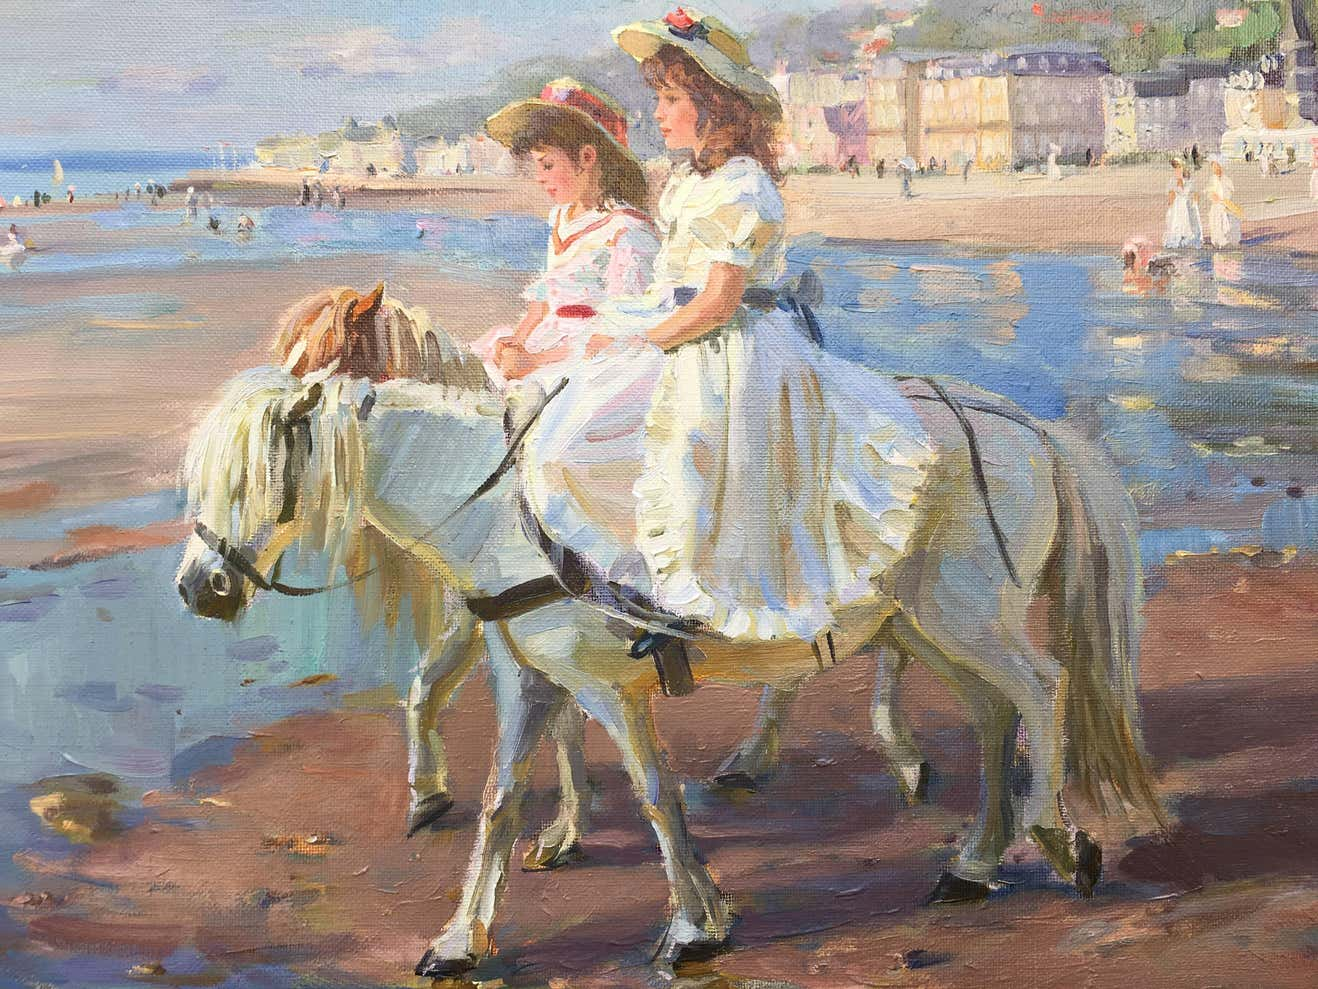

In [5]:
urls = [
        "https://a.1stdibscdn.com/alexander-averin-paintings-pony-riding-on-the-beach-post-impressionist-style-oil-painting-for-sale-picture-6/a_7443/a_28523631526593507117/Promenade_detalle_5_master.JPG?disable=upscale&auto=webp&quality=60&width=1318",
       ]

orig_images = list(filter(None,[download_image(url) for url in urls]))
media.show_images(orig_images)

## Optimize Prompt

In [6]:
learned_prompt = optimize_prompt(model, preprocess, args, device, target_images=orig_images)

step: 0, lr: 0.1, cosim: 0.053, text: davey chinaalee anthemythotimate ajay srugby 
step: 100, lr: 0.1, cosim: 0.312, text: llepaintings scones walks curran artist wildflowerhour ridden 
step: 200, lr: 0.1, cosim: 0.259, text: joannerajesh eid gloucester waterhouse alecoscino stouralecoscino 
step: 300, lr: 0.1, cosim: 0.366, text: piccadedmund madeline kathryn bicyalecoscino beach artiste 
step: 400, lr: 0.1, cosim: 0.397, text: perlflynn dolores reed ponies demonstrate boats artiste 
step: 500, lr: 0.1, cosim: 0.358, text: nigan clive dorset monmouth girl guerjubilee canvas 
step: 600, lr: 0.1, cosim: 0.287, text: heard aph 😂😂😂😂😂😂😂 suzuki maids priced fineartoils 
step: 700, lr: 0.1, cosim: 0.305, text: suffraaflo😂😂😂😂😂😂😂 downs children british pixelart paintings 
step: 800, lr: 0.1, cosim: 0.347, text: bournemouth amphibious gita horse gilt prado paintings galleria 
step: 900, lr: 0.1, cosim: 0.412, text: bournemouth sockvisitors ponies impressionism portrait european paintings 
step

## Generate with Stable Diffusion Model

In [7]:
# you can customize the learned prompt here
prompt = learned_prompt

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:04<00:00,  5.54it/s]


prompt: seaside children ponies suffraimpressionist paintings lottie hudson 



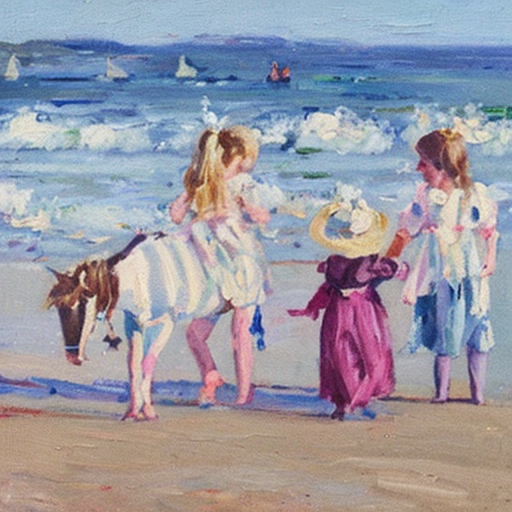
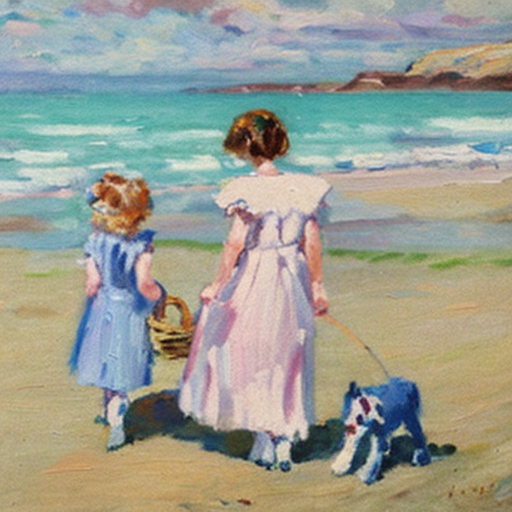
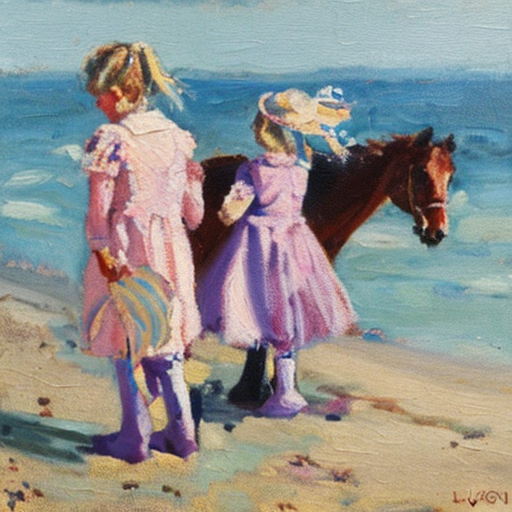
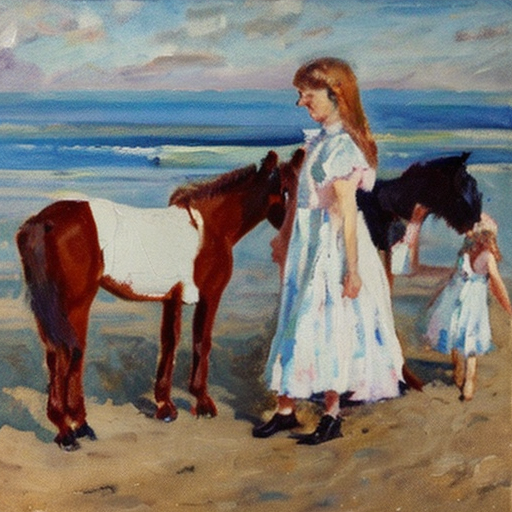

In [8]:
num_images = 4
guidance_scale = 9
num_inference_steps = 25

images = pipe(
    prompt,
    num_images_per_prompt=num_images,
    guidance_scale=guidance_scale,
    num_inference_steps=num_inference_steps,
    height=image_length,
    width=image_length,
    ).images

print(f"prompt: {prompt}")
media.show_images(images)